In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt, log

from acquire import acquire_data
from prepare import the_master_imputer, data_prep, percent_of_values_missing, change_data_to_int, change_data_to_object, zillow_single_unit_prop
from set_counties import create_county_cols
from summerize import summarize_data, show_distribution
from preprocessing import split_my_data, scale_data

# Acquire

- using our function from our acquire.py file to import our data from SQL and import it into a csv, drop the Unnamed column and assign it to a data frame
- in our SQL query we decided to eliminate all properties that were not a single unit family residential home
- we also cut some of our outliers by removing any home where their structuretaxvaluedollarcnt was > $1,000,000

In [2]:
df = acquire_data()

Acquiring data ...

- csv already exist

Data has been acquired


# Prepare

**more outlier control**

- this function below, limits our result's to include homes where the unit's square footage is no less than 500 sq ft, and no less than 1 bedroom and 1 bathroom 

In [3]:
df = zillow_single_unit_prop(df)

- our data_prep function removes any column missing 50% or more of their data as well as any row missing up to 75% of it's data (*We didn't want to waste time strategizing ways to accuratly sum up data missing over 50% of it's values*) 

In [4]:
df = data_prep(df)

- the function below tells us what percent of each column is missing

In [5]:
percent_of_values_missing(df)

parcelid                        0.00
logerror                        0.00
transactiondate                 0.00
bathroomcnt                     0.00
bedroomcnt                      0.00
calculatedfinishedsquarefeet    0.00
fips                            0.00
latitude                        0.00
longitude                       0.00
lotsizesquarefeet               0.62
regionidcity                    1.96
regionidcounty                  0.00
regionidzip                     0.04
yearbuilt                       0.06
structuretaxvaluedollarcnt      0.00
taxvaluedollarcnt               0.00
landtaxvaluedollarcnt           0.00
taxamount                       0.01
bed_bath_ratio                  0.00
tax_rate                        0.01
dtype: float64

- using the_master_imputer function, we will fill all of our missing functions with the median value, for that column's rows (*Since we weren't missing more than 2% of any data, we felt that the median would suffice for the missing values in our dataset*)

In [6]:
df = the_master_imputer(df)

We see that all of our missing values are taken care of

In [7]:
df.isna().sum()

parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
bed_bath_ratio                  0
tax_rate                        0
dtype: int64

>now we're going to take our fips # and use that to impute what county our observations were made in using our create_county_cols function and in the process we're going to drop our fips & our regioncounty columns.
fips source: [THIS LINK](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697)

In [8]:
df = create_county_cols(df)

### Lets change our values so we can have less noise in our exploration / modeling phase

- using our change_data_to_int function to change the datatypes of *yearbuilt*, *latitude*, *longitude*, *lotsizesquarefeet*, *calculatedfinishedsquarefeet*, *fips*, & *bedroomcnt* to change these datatypes from float's to integers to make the data more exclusive

In [9]:
cols = ['yearbuilt', 'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'fips' ]
df = change_data_to_int(df, cols)

- using our change_data_to_object function to change the datatypes of *parcelid*, *regionidcity*, *regionidcounty*, *fips* & *regionidzip* to object. (we dont want to do any addition with our unit id's)

In [10]:
cols = ['parcelid', 'regionidzip', 'regionidcity', 'LA', 'Ventura', 'Orange', 'fips', 'regionidcounty']
df = change_data_to_object(df, cols)

### We're going summarize what our data looks like
- this functions runs a .info, a .describe and a .shape on our data and returns it in a pandas series

In [11]:
# uncomment to run function
#summarize_data(df)

## Preprocessing

- using split_my_data function to split our data into train, test and validate data frames

In [12]:
train, test, val = split_my_data(df, .15, .50)

- using scale_data function to scale our data with MinMaxScaler()

In [13]:
train_scaled = train[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'lotsizesquarefeet']]
train_scaled, scaler = scale_data(train_scaled)
train[['scaled_taxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt', 'scaled_lotsizesquarefeet']] = train_scaled[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'lotsizesquarefeet']]

# Exploration

- Perform clustering with logerror, longitude & latitude

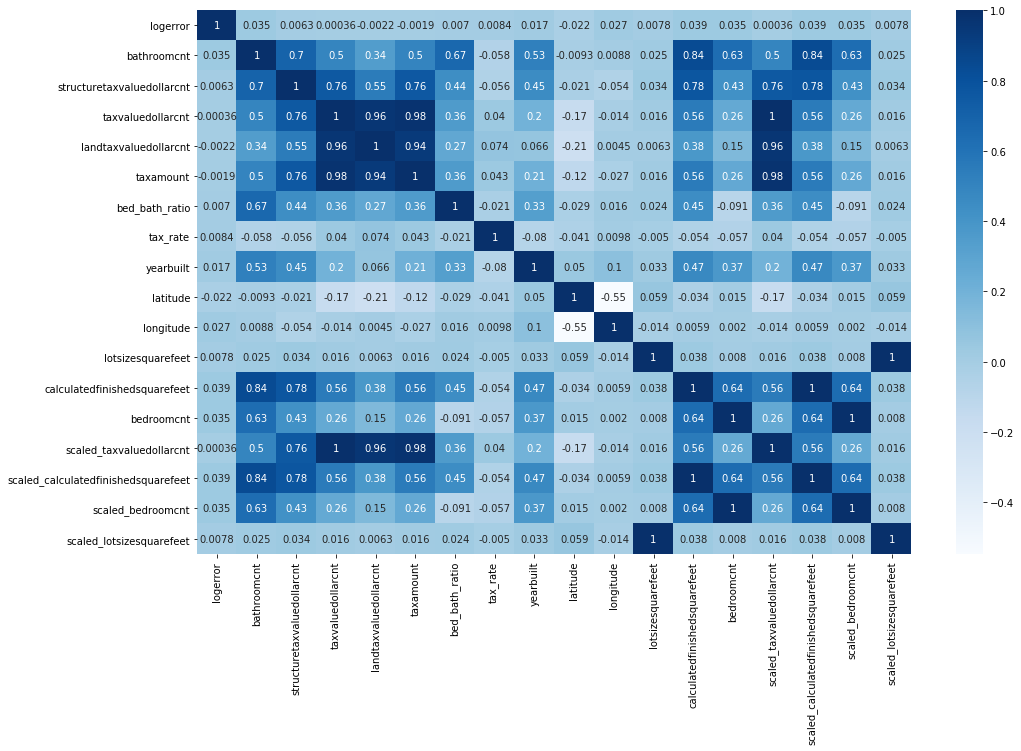

In [14]:
# Overall correlation of the features and the target.
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [15]:
X = train[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['log_cluster'] = kmeans.predict(X)

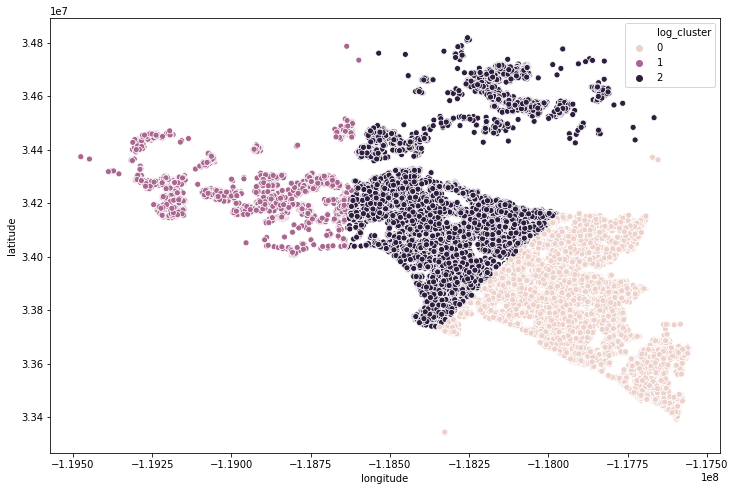

In [16]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude' , hue='log_cluster', data=train)

- 3 distinct clusters of areas found using longitude and latitude
- lets find out if they're correlated with our counties by visualizing our longitude, latitude and hue it by county

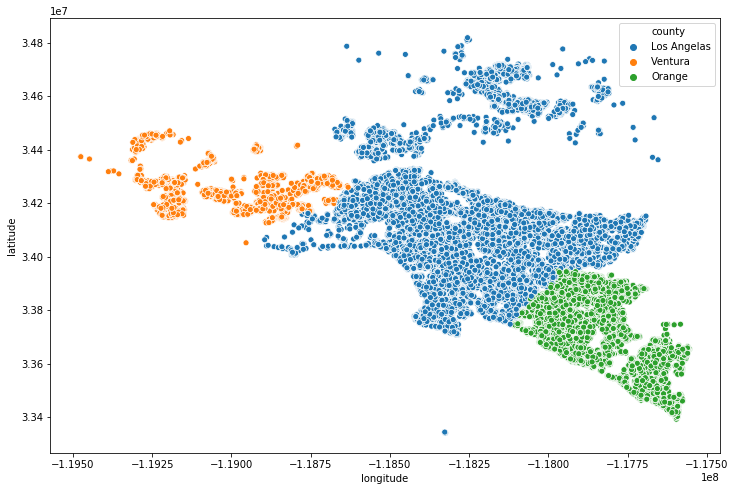

In [17]:
plt.figure(figsize=(12,8))
sns.scatterplot('longitude', 'latitude', hue='county', data=train)

- visually looks incredibly similar.
- tells us that their logerror algorithm is dependent on where a home is located 

In [18]:
X = train[['logerror','scaled_calculatedfinishedsquarefeet' ]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

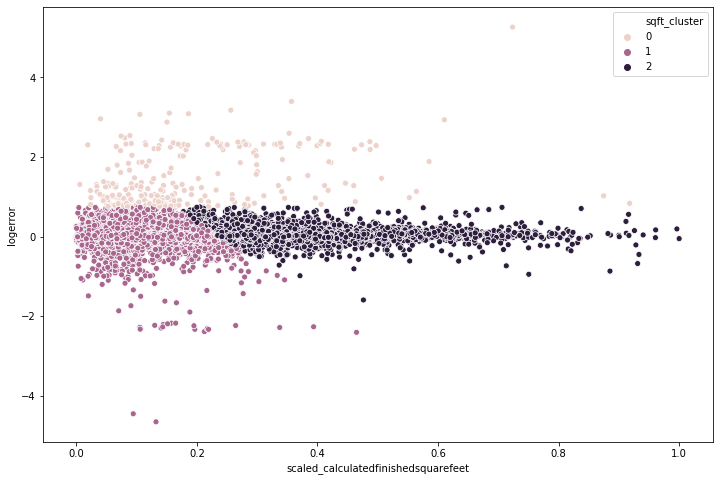

In [19]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

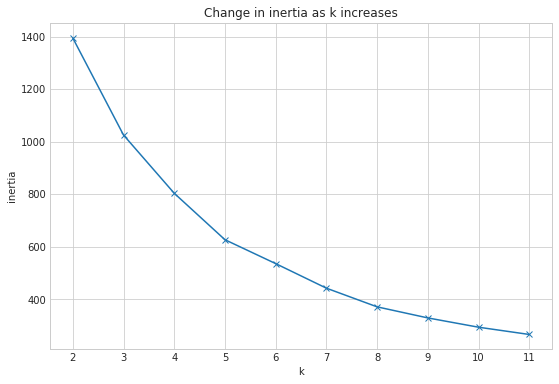

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- looks like the optimal k value would be about 5

In [21]:
X = train[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

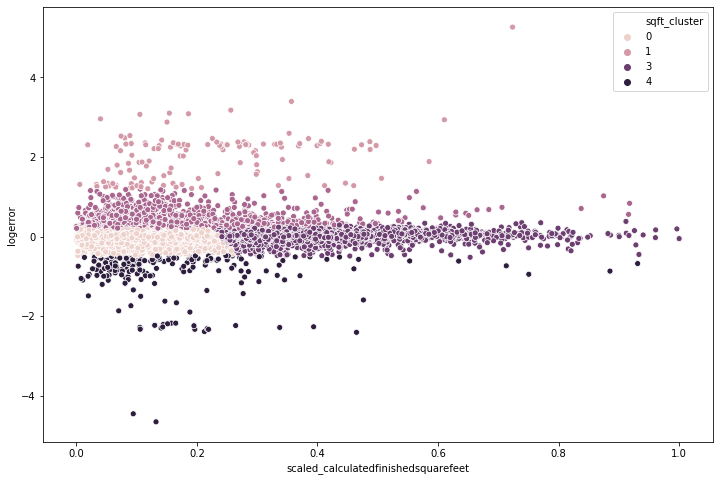

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

In [23]:
X = train[['logerror', 'scaled_taxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['money_bed_cluster'] = kmeans.predict(X)

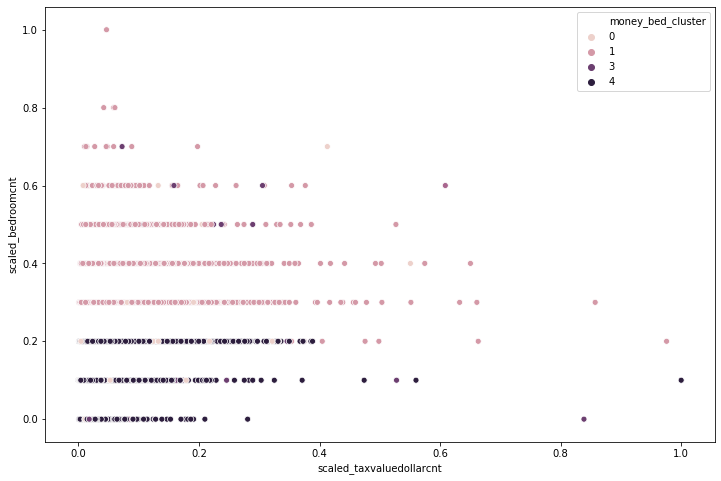

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='scaled_taxvaluedollarcnt', y='scaled_bedroomcnt', hue='money_bed_cluster', data=train)

In [25]:
X = train[['logerror', 'yearbuilt']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['yearbuilt_cluster'] = kmeans.predict(X)

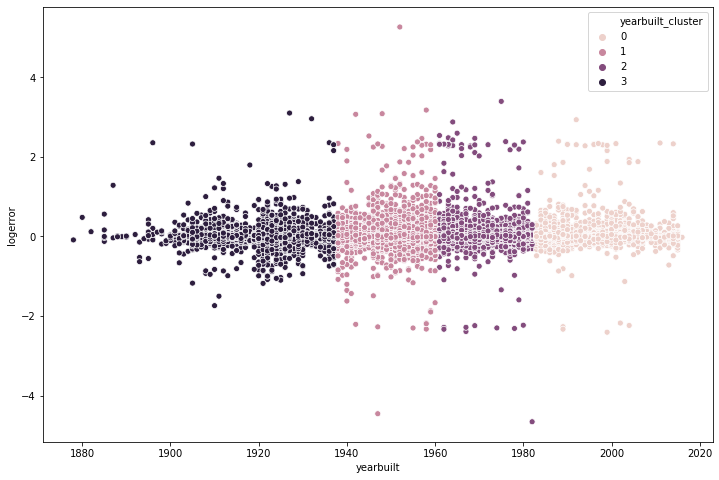

In [26]:
plt.figure(figsize=(12,8))
sns.scatterplot('yearbuilt', 'logerror', hue='yearbuilt_cluster', data=train)

In [27]:
X = train[['logerror', 'bed_bath_ratio']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['bed_bath_ratio_cluster'] = kmeans.predict(X)

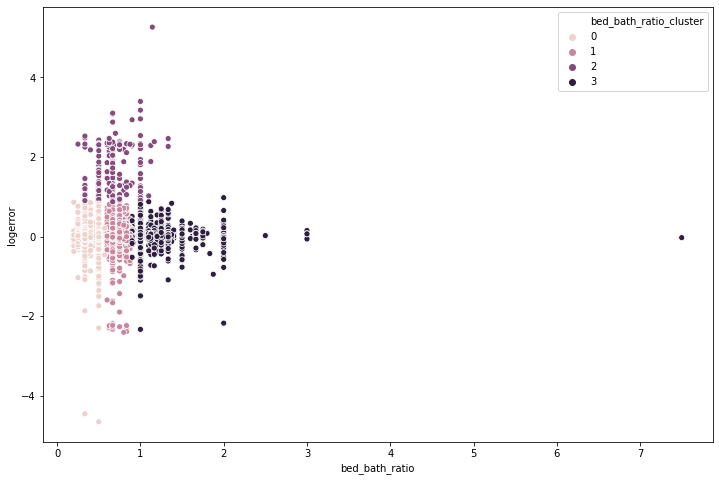

In [28]:
plt.figure(figsize=(12,8))
sns.scatterplot('bed_bath_ratio', 'logerror', hue='bed_bath_ratio_cluster', data=train)

In [29]:
X = train[['logerror', 'tax_rate']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['tax_rate_cluster'] = kmeans.predict(X)

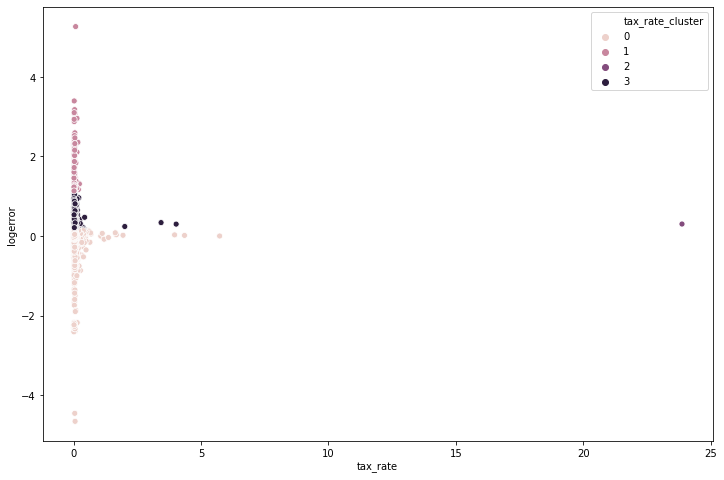

In [30]:
plt.figure(figsize=(12,8))
sns.scatterplot('tax_rate', 'logerror', hue='tax_rate_cluster', data=train)

In [31]:
X = train[['logerror', 'scaled_lotsizesquarefeet']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['lotsizesquarefeet_cluster'] = kmeans.predict(X)

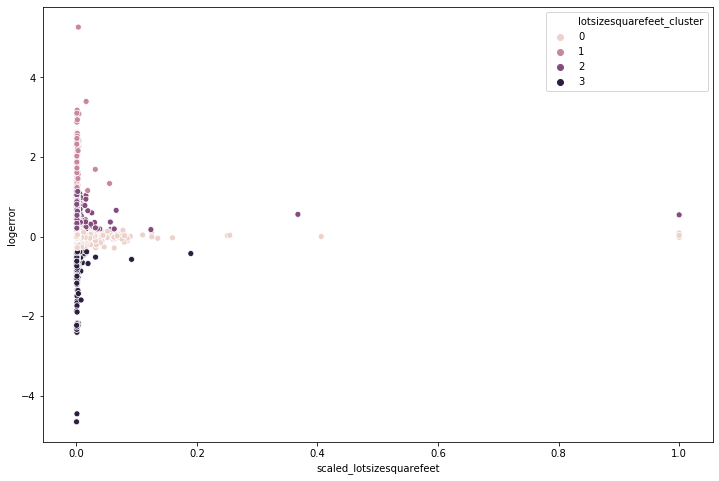

In [32]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_lotsizesquarefeet', 'logerror', hue='lotsizesquarefeet_cluster', data=train)

# Modeling

- We used a *linear regression*, and *polynomial regression* algorithms to predict logerror

- The data used have been all of our features and specified clusters

#### step 1 encode the county column

In [33]:
# run this function
def encode(train, test, col_name):
    from sklearn.preprocessing import LabelEncoder
    
    # Integer Encoding
    int_encoder = LabelEncoder()
    train[col_name] = int_encoder.fit_transform(train[col_name])
    test[col_name] = int_encoder.transform(test[col_name])
    
    return train, test

In [34]:
train, val = encode(train, val, 'county')

#### step 2 split our train and validate data sets in X_train,and X_val's

In [35]:
X_train = train[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = train[['logerror']]
X_val = val[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = val[['logerror']]

#### step 3 create the baseline model

In [36]:
predictions = pd.DataFrame()
predictions['actual'] = y_train['logerror']

predictions['baseline'] = y_train.logerror.mean()

In [37]:
predictions.head()

,actual,baseline
230,0.090921,0.017734
37011,0.188178,0.017734
19770,0.044840,0.017734
50681,-0.040180,0.017734
37426,-0.060420,0.017734


#### step 4 create linear model

In [38]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### step 5 evaluate the model

In [39]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = (r2_score(y_pred_val, y_val))

>add our predictions to our predictions data frame

In [40]:
predictions['logerror_lm'] = y_train_pred

predictions.head()

,actual,baseline,logerror_lm
230,0.090921,0.017734,0.012074
37011,0.188178,0.017734,0.015042
19770,0.044840,0.017734,0.022961
50681,-0.040180,0.017734,0.029269
37426,-0.060420,0.017734,0.014274


#### Outcome of the linear regression model

In [41]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 score of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of test set is {rmse_val}")
print("R2 score of test set is {}".format(r2_score(y_pred_val, y_val)))

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.17644995948457112
R2 score of training set is 0.0017691872822013233
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of test set is 0.15549926488398447
R2 score of test set is -465.16615787662886


#### now we plot our model

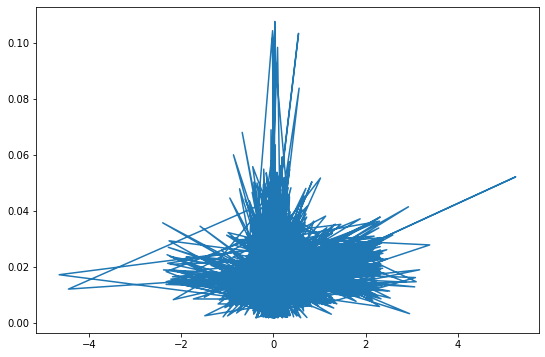

In [42]:
x = predictions.actual
y = predictions.logerror_lm
plt.figure(figsize=(9, 6))
plt.plot(x, y)

### model with clusters

In [43]:
train.taxvaluedollarcnt.mean()

474937.59409205406

In [44]:
logerror = pd.DataFrame()
#logerror['baseline_predictions'] = train.taxvaluedollarcnt.mean()

In [59]:
logerror.head()

,actual,baseline_predictions,baseline_logerror
230,169738.0,474937.594092,1.028927
37011,452670.0,474937.594092,0.048020
19770,431859.0,474937.594092,0.095084
50681,1053673.0,474937.594092,-0.796854
37426,172592.0,474937.594092,1.012253


In [46]:
logerror['actual'] = train.taxvaluedollarcnt

In [47]:
logerror['baseline_predictions'] = train.taxvaluedollarcnt.mean()

In [48]:
logerror.head()

,actual,baseline_predictions
230,169738.0,474937.594092
37011,452670.0,474937.594092
19770,431859.0,474937.594092
50681,1053673.0,474937.594092
37426,172592.0,474937.594092


In [49]:
logerror['baseline_logerror'] = np.log(logerror.baseline_predictions) - np.log(logerror.actual)

In [50]:
logerror.head()

,actual,baseline_predictions,baseline_logerror
230,169738.0,474937.594092,1.028927
37011,452670.0,474937.594092,0.048020
19770,431859.0,474937.594092,0.095084
50681,1053673.0,474937.594092,-0.796854
37426,172592.0,474937.594092,1.012253


logerror = MAE(log(zestimate) - log(sale price))

In [51]:
train.head()

,logerror,transactiondate,bathroomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,bed_bath_ratio,tax_rate,county,...,scaled_calculatedfinishedsquarefeet,scaled_bedroomcnt,scaled_lotsizesquarefeet,log_cluster,sqft_cluster,money_bed_cluster,yearbuilt_cluster,bed_bath_ratio_cluster,tax_rate_cluster,lotsizesquarefeet_cluster
230,0.090921,2017-01-03,2.0,101849.0,169738.0,67889.0,2082.42,0.666667,0.020446,0,...,0.083947,0.2,0.001064,2,0,4,1,1,0,0
37011,0.188178,2017-07-10,1.5,226335.0,452670.0,226335.0,4848.08,0.500000,0.021420,2,...,0.068952,0.2,0.001385,1,0,0,2,0,3,2
19770,0.044840,2017-04-26,2.0,151204.0,431859.0,280655.0,5083.76,0.500000,0.033622,2,...,0.186103,0.3,0.000969,1,0,1,2,0,0,0
50681,-0.040180,2017-09-13,2.5,458083.0,1053673.0,595590.0,12137.42,0.625000,0.026496,1,...,0.396706,0.3,0.001903,0,3,1,0,1,0,0
37426,-0.060420,2017-07-12,2.0,138074.0,172592.0,34518.0,2966.29,0.666667,0.021483,0,...,0.142991,0.2,0.000974,2,0,4,0,1,0,0


In [52]:
check = pd.DataFrame()

In [53]:
check['actual'] = np.log(train['taxvaluedollarcnt'])

In [54]:
check['pred'] = log(train.taxvaluedollarcnt.mean())

In [55]:
check.head()

,actual,pred
230,12.042011,13.070939
37011,13.022919,13.070939
19770,12.975854,13.070939
50681,13.867793,13.070939
37426,12.058686,13.070939


In [56]:
check['logerror'] = mean_absolute_error(check['pred'], check['actual'])

In [57]:
check.head()

,actual,pred,logerror
230,12.042011,13.070939,0.745299
37011,13.022919,13.070939,0.745299
19770,12.975854,13.070939,0.745299
50681,13.867793,13.070939,0.745299
37426,12.058686,13.070939,0.745299


In [58]:
def calculate_logerror(actual, predicted, df):
    df[f'{actual}'] = np.log(df[f'{actual}'])
    df[f'{predicted}'] = np.log
    